# Trajectory models

Generative models of individual trajectories

In [1]:
import skmob
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Exploration and Preferential Return EPR

### Density EPR

In [2]:
from skmob.models.epr import DensityEPR

In [3]:
tessellation = gpd.GeoDataFrame.from_file("./data/NY_counties_2011.geojson")
start_time = pd.to_datetime('2019/01/01 08:00:00')
end_time = pd.to_datetime('2019/01/14 08:00:00')

In [4]:
depr = DensityEPR()

In [5]:
tdf = depr.generate(start_time, end_time, tessellation, 
                    relevance_column='population',
                    n_agents=100, od_matrix=None, verbose=True)

100%|██████████| 100/100 [00:04<00:00, 21.74it/s]


In [6]:
print(type(tdf))
tdf.parameters

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


{'model': {'class': <function skmob.models.epr.DensityEPR.__init__(self, name='Density EPR model', rho=0.6, gamma=0.21, beta=0.8, tau=17, min_wait_time_minutes=20)>,
  'generate': {'start_date': Timestamp('2019-01-01 08:00:00'),
   'end_date': Timestamp('2019-01-14 08:00:00'),
   'gravity_singly': {},
   'n_agents': 100,
   'relevance_column': 'population',
   'random_state': None,
   'verbose': True}}}

In [7]:
tdf.head() 

,uid,datetime,lat,lng
0,1,2019-01-01 08:00:00.000000,43.241550,-75.435903
1,1,2019-01-01 10:34:40.160725,42.758231,-78.779632
2,1,2019-01-01 10:58:23.662858,42.600164,-73.973506
3,1,2019-01-01 11:38:36.507690,42.758231,-78.779632
4,1,2019-01-01 12:09:29.628554,43.309133,-77.680414


In [8]:
from skmob.preprocessing import detection, clustering
dtdf = detection.stops(tdf)
ctdf = clustering.cluster(dtdf)

In [9]:
uid = 2
m = tdf[tdf['uid'] == uid].plot_trajectory(zoom=7)
ctdf[ctdf['uid'] == uid].plot_stops(map_f=m)

/home/darshan/anaconda3/envs/test/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


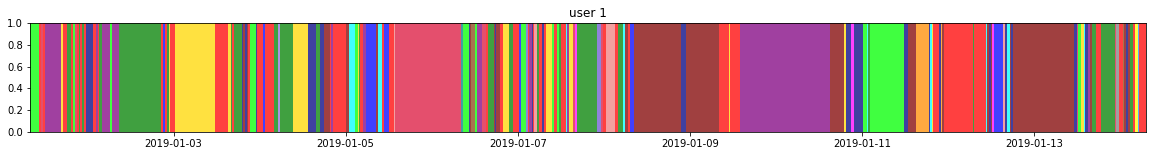

In [10]:
ax = ctdf.plot_diary(user=1)

Now that we have a TrajDataFrame, we can compute the individual and collective measures

In [11]:
from skmob.measures.individual import jump_lengths
from skmob.measures.individual import radius_of_gyration, waiting_times

/home/darshan/anaconda3/envs/test/lib/python3.7/site-packages/tqdm-4.37.0-py3.7.egg/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [12]:
jls = jump_lengths(tdf, merge=True)
jls[:5]

100%|██████████| 100/100 [00:00<00:00, 551.85it/s]


[277.16145667805864,
 393.22184680406,
 393.22184680406,
 108.32459178795331,
 88.25980625297235]

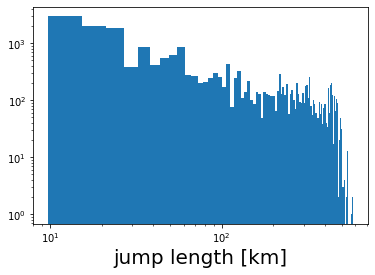

In [13]:
plt.hist(jls, bins=100)
plt.xlabel('jump length [km]', fontsize=20)
plt.loglog()
plt.show()

In [14]:
wts = waiting_times(tdf, merge=True)
wts[:5]

100%|██████████| 100/100 [00:00<00:00, 1430.07it/s]


[9280.0, 1423.0, 2412.0, 1853.0, 15904.0]

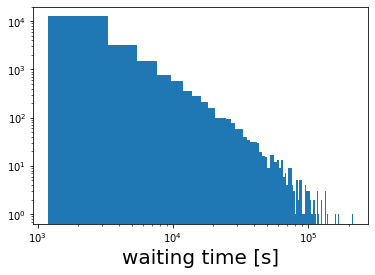

In [15]:
plt.hist(wts, bins=100)
plt.xlabel('waiting time [s]', fontsize=20)
plt.loglog()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 745.08it/s]


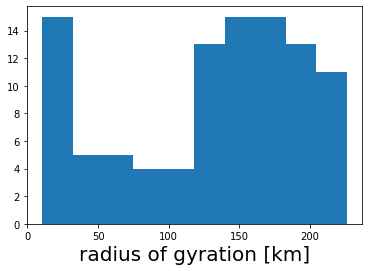

In [16]:
rg_df = radius_of_gyration(tdf)
plt.hist(rg_df.radius_of_gyration.values, bins=10)
plt.xlabel('radius of gyration [km]', fontsize=20)
plt.show()

### DITRAS

In [17]:
from skmob.models.epr import Ditras
from skmob.models.markov_diary_generator import MarkovDiaryGenerator
from skmob.preprocessing import filtering, compression, detection, clustering

In [18]:
tdf = skmob.TrajDataFrame.from_file('./data/geolife_sample.txt.gz', 
                                     latitude='lat', longitude='lon', user_id='user', 
                                     datetime='datetime', sep=',')
ctdf = compression.compress(tdf)
stdf = detection.stops(ctdf)
cstdf = clustering.cluster(stdf)
cstdf[:5]

,lat,lng,datetime,uid,leaving_datetime,cluster
0,39.978253,116.327275,2008-10-23 06:01:05,1,2008-10-23 10:32:53,0
1,40.013819,116.306532,2008-10-23 11:10:09,1,2008-10-23 23:46:02,1
2,39.978987,116.326686,2008-10-24 00:10:39,1,2008-10-24 01:48:57,0
3,39.981316,116.310181,2008-10-24 01:56:47,1,2008-10-24 03:21:09,6
4,39.979580,116.313649,2008-10-24 03:26:35,1,2008-10-24 03:50:36,45


In [19]:
mdg = MarkovDiaryGenerator()
mdg.fit(cstdf, 2, lid='cluster')

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


In [20]:
start_time = pd.to_datetime('2019/01/01 08:00:00')
end_time = pd.to_datetime('2019/01/14 08:00:00')
ditras = Ditras(mdg)

In [21]:
tdf = ditras.generate(start_time, end_time, tessellation, relevance_column='population',
                    n_agents=3, od_matrix=None, verbose=True)

100%|██████████| 3/3 [00:00<00:00, 38.46it/s]


In [22]:
tdf.head()

,uid,datetime,lat,lng
0,1,2019-01-01 08:00:00,43.463955,-76.208699
1,1,2019-01-01 12:00:00,43.005839,-76.194622
2,1,2019-01-01 14:00:00,43.463955,-76.208699
3,1,2019-01-02 13:00:00,43.005839,-76.194622
4,1,2019-01-02 14:00:00,43.463955,-76.208699


In [23]:
dtdf = detection.stops(tdf)
ctdf = clustering.cluster(dtdf)

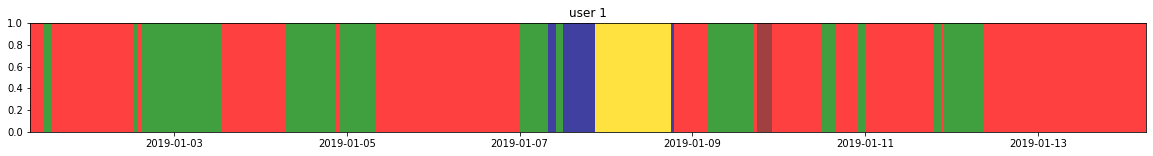

In [24]:
ax = ctdf.plot_diary(user=1)